In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import re
import nltk
import math
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import sklearn.metrics
from sklearn.metrics import confusion_matrix
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from imblearn.over_sampling import SMOTE

%matplotlib inline

In [2]:
df = pd.read_csv('xtal_2.csv',header = None)
df.head(10)

,0,1,2
0,ATCG3D_18,DYKDDDDAMGQPGNGSAFLLAPNRSHAPDHDVTQQRDEVWVVGMGI...,1
1,BSGCAIR30348,MDKKYDITAVLNEDSSMTAISDQFQITLDARPKHTAKGFGPLAALL...,1
2,BSGCAIR30512,MTESFTRRERLRLRRDFLLIFKEGKSLQNEYFVVLFRKNGLDYSRL...,1
3,BSGCAIR30561,MEHDERTHVPVELRAAGVVLLNERGDILLVQEKGIPGHPEKAGLWH...,1
4,BSGCAIR30591,MFYKEENFKKTEIGEIPEDWEIVELKDVCKKIKAGGTPKTSVEEYY...,1
5,BSGCAIR30656,MAIRLYKLAVALGVFIVSAPAFSHGHHSHGKPLTEVEQKAANGVFD...,1
6,BSGCAIR31213,MKDIDTLISNNALWSKMLVEEDPGFFEKLAQAQKPRFLWIGCSDSR...,1
7,GO.102486,GSHMQRQRPPSRAGGDMDRLQSALALYEEAMGYTYAAALRAAAAVG...,1
8,GO.102706,LDQILRATVEEVRAFLGTDRVKVYRFDPEGHGTVVAEARGGERLPS...,1
9,GO.110986,GSPDPEIFRQRFRQFGYQDSPGPREAVSQLRELCRLWLRPETHTKE...,1


In [3]:
df.columns = ['id','sequence','result']
df.head()

,id,sequence,result
0,ATCG3D_18,DYKDDDDAMGQPGNGSAFLLAPNRSHAPDHDVTQQRDEVWVVGMGI...,1
1,BSGCAIR30348,MDKKYDITAVLNEDSSMTAISDQFQITLDARPKHTAKGFGPLAALL...,1
2,BSGCAIR30512,MTESFTRRERLRLRRDFLLIFKEGKSLQNEYFVVLFRKNGLDYSRL...,1
3,BSGCAIR30561,MEHDERTHVPVELRAAGVVLLNERGDILLVQEKGIPGHPEKAGLWH...,1
4,BSGCAIR30591,MFYKEENFKKTEIGEIPEDWEIVELKDVCKKIKAGGTPKTSVEEYY...,1


In [4]:
df.shape

(4791, 3)

In [5]:
df.dtypes

id          object
sequence    object
result       int64
dtype: object

In [6]:
# Count the number of 0's(failures) & 1's,(success) in the result column
df.groupby('result')['result'].value_counts()

result  result
0       0         3913
1       1          878
Name: result, dtype: int64

In [7]:
df['sequence'] = df['sequence'].str.replace('X','G')

## Derive Features Using Biopython

In [8]:
df['MW'] = df['sequence'].apply(lambda seq: ProteinAnalysis(seq).molecular_weight())

In [9]:
df['grav'] = df['sequence'].apply(lambda seq: ProteinAnalysis(seq).gravy())

In [10]:
df['instability'] = df['sequence'].apply(lambda seq: ProteinAnalysis(seq).instability_index())

In [11]:
df['isoelectric'] = df['sequence'].apply(lambda seq: ProteinAnalysis(seq).isoelectric_point())

In [12]:
df['aromaticity'] = df['sequence'].apply(lambda seq: ProteinAnalysis(seq).aromaticity())

In [13]:
df['helix'] = df['sequence'].apply(lambda seq: ProteinAnalysis(seq).secondary_structure_fraction()[0])

In [14]:
df.head()

,id,sequence,result,MW,grav,instability,isoelectric,aromaticity,helix
0,ATCG3D_18,DYKDDDDAMGQPGNGSAFLLAPNRSHAPDHDVTQQRDEVWVVGMGI...,1,55892.4681,0.149796,36.865122,8.900085,0.118367,0.375510
1,BSGCAIR30348,MDKKYDITAVLNEDSSMTAISDQFQITLDARPKHTAKGFGPLAALL...,1,15468.5888,-0.114184,44.349645,6.499084,0.056738,0.283688
2,BSGCAIR30512,MTESFTRRERLRLRRDFLLIFKEGKSLQNEYFVVLFRKNGLDYSRL...,1,14316.7996,-0.582051,53.325641,11.247742,0.119658,0.384615
3,BSGCAIR30561,MEHDERTHVPVELRAAGVVLLNERGDILLVQEKGIPGHPEKAGLWH...,1,17568.7576,-0.200629,56.282453,5.010071,0.081761,0.308176
4,BSGCAIR30591,MFYKEENFKKTEIGEIPEDWEIVELKDVCKKIKAGGTPKTSVEEYY...,1,48567.0197,-0.443059,33.561694,9.300720,0.082353,0.329412


In [15]:
df.tail()

,id,sequence,result,MW,grav,instability,isoelectric,aromaticity,helix
4786,MytuD.00386.a,MSDLVRVERKGRVTTVILNRPASRNAVNGPTAAALCAAFEQFDRDD...,0,27441.1254,0.058555,40.635741,7.688293,0.04943,0.250951
4787,MytuD.00386.a,MSDLVRVERKGRVTTVILNRPASRNAVNGPTAAALCAAFEQFDRDD...,0,27441.1254,0.058555,40.635741,7.688293,0.04943,0.250951
4788,MytuD.00386.a,MSDLVRVERKGRVTTVILNRPASRNAVNGPTAAALCAAFEQFDRDD...,0,27441.1254,0.058555,40.635741,7.688293,0.04943,0.250951
4789,MytuD.00386.a,MSDLVRVERKGRVTTVILNRPASRNAVNGPTAAALCAAFEQFDRDD...,0,27441.1254,0.058555,40.635741,7.688293,0.04943,0.250951
4790,MytuD.00386.a,MSDLVRVERKGRVTTVILNRPASRNAVNGPTAAALCAAFEQFDRDD...,0,27441.1254,0.058555,40.635741,7.688293,0.04943,0.250951


In [16]:
def xtal_ornot(val):
    if val == 1:
        return 'crystal'
    else:
        return 'none'

In [17]:
df['status'] = df.result.apply(xtal_ornot)

In [18]:
df.status.value_counts()

none       3913
crystal     878
Name: status, dtype: int64

In [19]:
df.columns

Index(['id', 'sequence', 'result', 'MW', 'grav', 'instability', 'isoelectric',
       'aromaticity', 'helix', 'status'],
      dtype='object')

In [20]:
df.dtypes

id              object
sequence        object
result           int64
MW             float64
grav           float64
instability    float64
isoelectric    float64
aromaticity    float64
helix          float64
status          object
dtype: object

## EDA

/Users/scottlew/miniconda3/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


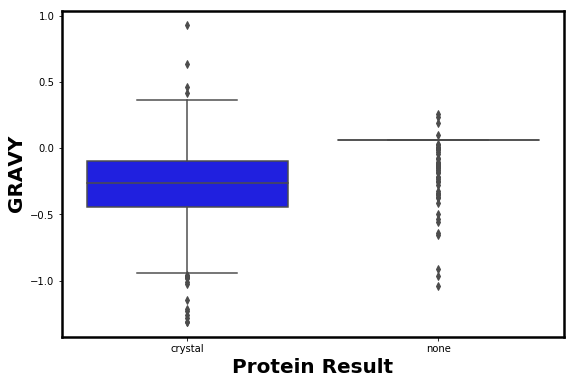

In [21]:
#sns.boxplot()
my_pal = {"none": "r", "crystal": "b"}
fig, ax = plt.subplots(figsize=(9, 6))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2.5)
sns.boxplot(x="status", y="grav", data=df, palette=my_pal)
plt.xlabel('Protein Result',weight = 'bold',size =20)
plt.ylabel('GRAVY',weight = 'bold',size =20)

## Balanced Dataset

## Create small dataframe of equal number of proteins that crystallized & ones that did not crystallize.

In [22]:
crystals = df[df.result == 1]
crystals.head()

,id,sequence,result,MW,grav,instability,isoelectric,aromaticity,helix,status
0,ATCG3D_18,DYKDDDDAMGQPGNGSAFLLAPNRSHAPDHDVTQQRDEVWVVGMGI...,1,55892.4681,0.149796,36.865122,8.900085,0.118367,0.375510,crystal
1,BSGCAIR30348,MDKKYDITAVLNEDSSMTAISDQFQITLDARPKHTAKGFGPLAALL...,1,15468.5888,-0.114184,44.349645,6.499084,0.056738,0.283688,crystal
2,BSGCAIR30512,MTESFTRRERLRLRRDFLLIFKEGKSLQNEYFVVLFRKNGLDYSRL...,1,14316.7996,-0.582051,53.325641,11.247742,0.119658,0.384615,crystal
3,BSGCAIR30561,MEHDERTHVPVELRAAGVVLLNERGDILLVQEKGIPGHPEKAGLWH...,1,17568.7576,-0.200629,56.282453,5.010071,0.081761,0.308176,crystal
4,BSGCAIR30591,MFYKEENFKKTEIGEIPEDWEIVELKDVCKKIKAGGTPKTSVEEYY...,1,48567.0197,-0.443059,33.561694,9.300720,0.082353,0.329412,crystal


In [23]:
crystals.shape

(878, 10)

In [24]:
no_xtal = df[df.result == 0]
no_xtal.head()

,id,sequence,result,MW,grav,instability,isoelectric,aromaticity,helix,status
426,APC7908,MNQHLLGNPKLTVTHVNEVKAGINHIVVDSVQYGNQEMIMEKDGTV...,0,64247.1960,-0.637500,33.412911,5.361267,0.114286,0.303571,none
439,APC7603,MSETATWQPSASIPNLLKRAAIMAEIRRFFADRGVLEVETPCMSQA...,0,36855.3571,-0.340923,46.948000,5.113708,0.083077,0.283077,none
519,hsk002000585.2,RRAGSVKRGEARLFGPTERQSERPLRPSAARRPEMLSGKKAAAAAA...,0,96758.8193,-0.413995,42.953725,6.816711,0.065463,0.261851,none
881,GO.35285,MARRKRRNFSKQASEILNEYFYSHLSNPYPSEEAKEELARKCGITV...,0,9610.7849,-0.961905,74.678690,9.946838,0.107143,0.226190,none
882,GO.36643,SEKLAASTEPQGPRPVLGRESVQVPDDQDFRSFRSECEAEVGWNLT...,0,33004.2342,-0.531271,50.902749,6.654846,0.085911,0.285223,none


In [25]:
no_xtal.shape

(3913, 10)

In [26]:
df_xtal = crystals.sample(n=400)
df_no_xtal = no_xtal.sample(n=400)

In [27]:
df_xtal.shape

(400, 10)

In [28]:
df_no_xtal.shape

(400, 10)

In [29]:
# concat the two dataframes
df_rand = pd.concat([df_xtal,df_no_xtal])
# permute/scramble/shuffle rows of the dataframe
df_rand = df_rand.sample(frac=1)
df_rand.head(3)

,id,sequence,result,MW,grav,instability,isoelectric,aromaticity,helix,status
3057,MytuD.00386.a,MSDLVRVERKGRVTTVILNRPASRNAVNGPTAAALCAAFEQFDRDD...,0,27441.1254,0.058555,40.635741,7.688293,0.04943,0.250951,none
4370,MytuD.00386.a,MSDLVRVERKGRVTTVILNRPASRNAVNGPTAAALCAAFEQFDRDD...,0,27441.1254,0.058555,40.635741,7.688293,0.04943,0.250951,none
3903,MytuD.00386.a,MSDLVRVERKGRVTTVILNRPASRNAVNGPTAAALCAAFEQFDRDD...,0,27441.1254,0.058555,40.635741,7.688293,0.04943,0.250951,none


In [30]:
df_rand.shape

(800, 10)

In [31]:
df_rand.dtypes

id              object
sequence        object
result           int64
MW             float64
grav           float64
instability    float64
isoelectric    float64
aromaticity    float64
helix          float64
status          object
dtype: object

In [32]:
#print(vect_3.get_feature_names())

In [33]:
predictors = ['MW', 'grav', 'instability', 'isoelectric','aromaticity', 'helix']
X = df_rand[predictors]
y = df_rand.result

## Split the data into training & test sets

In [34]:
# Note: will try to split the data first, then transform with the vectorizer
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state =42)

In [35]:
# Count the number of 0's(failures) & 1's,(success) in the result column
y_train.value_counts()

0    325
1    315
Name: result, dtype: int64

In [36]:
X_train.shape

(640, 6)

In [37]:
# Count the number of 0's(failures) & 1's,(success) in the result column
y_test.value_counts()

1    85
0    75
Name: result, dtype: int64

In [38]:
#X_train

In [39]:
#X_test

In [40]:
y_train

3631    0
1105    0
87      1
355     1
766     1
       ..
4471    0
967     0
3426    0
985     0
160     1
Name: result, Length: 640, dtype: int64

In [41]:
y_test.value_counts()

1    85
0    75
Name: result, dtype: int64

In [42]:
# Logistic Regression 
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.predict(X_test)
print("Logistic Regression Score For Balanced Dataset: {:.2f}".format(lr.score(X_test, y_test)))

Logistic Regression Score For Balanced Dataset: 0.94


/Users/scottlew/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [43]:
# Generate Confusion Matrix for Logistic Regression
actual = y_test
predictions = lr.predict(X_test)
print('Confusion Matrix for Logistic Regression Model Using Balanced Data')
print()
cm = confusion_matrix(actual,predictions)
print(cm)

Confusion Matrix for Logistic Regression Model Using Balanced Data

[[74  1]
 [ 9 76]]


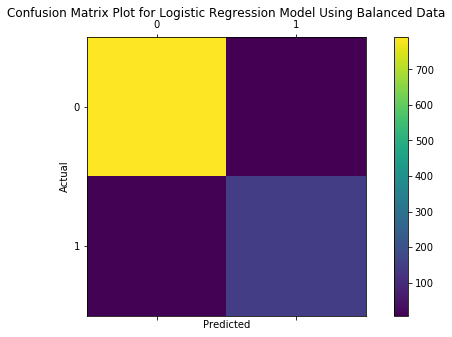

In [76]:
# Nice plot of confusion matrix
# Adjust size of confusion matrix by following code taken from StackOverflow
# https://stackoverflow.com/questions/43021762/matplotlib-how-to-change-figsize-for-matshow
plt.figure(figsize=(10,5))
plt.matshow(cm, fignum=1)

plt.title('Confusion Matrix Plot for Logistic Regression Model Using Balanced Data')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

## Logistic Regression On The Entire Data: Unbalanced data set where more proteins failed to crystallize than those that did crystallize.

In [45]:
# scramble the data before using and splitting
data = df.sample(frac=1)
data.shape

(4791, 10)

In [46]:
df.head(3)

,id,sequence,result,MW,grav,instability,isoelectric,aromaticity,helix,status
0,ATCG3D_18,DYKDDDDAMGQPGNGSAFLLAPNRSHAPDHDVTQQRDEVWVVGMGI...,1,55892.4681,0.149796,36.865122,8.900085,0.118367,0.375510,crystal
1,BSGCAIR30348,MDKKYDITAVLNEDSSMTAISDQFQITLDARPKHTAKGFGPLAALL...,1,15468.5888,-0.114184,44.349645,6.499084,0.056738,0.283688,crystal
2,BSGCAIR30512,MTESFTRRERLRLRRDFLLIFKEGKSLQNEYFVVLFRKNGLDYSRL...,1,14316.7996,-0.582051,53.325641,11.247742,0.119658,0.384615,crystal


In [47]:
data.head(3)

,id,sequence,result,MW,grav,instability,isoelectric,aromaticity,helix,status
3896,MytuD.00386.a,MSDLVRVERKGRVTTVILNRPASRNAVNGPTAAALCAAFEQFDRDD...,0,27441.1254,0.058555,40.635741,7.688293,0.04943,0.250951,none
2253,MytuD.00386.a,MSDLVRVERKGRVTTVILNRPASRNAVNGPTAAALCAAFEQFDRDD...,0,27441.1254,0.058555,40.635741,7.688293,0.04943,0.250951,none
1545,MytuD.00386.a,MSDLVRVERKGRVTTVILNRPASRNAVNGPTAAALCAAFEQFDRDD...,0,27441.1254,0.058555,40.635741,7.688293,0.04943,0.250951,none


In [48]:
data.groupby('result')['result'].value_counts()

result  result
0       0         3913
1       1          878
Name: result, dtype: int64

In [49]:
predictors = ['MW', 'grav', 'instability', 'isoelectric','aromaticity', 'helix']

X = data[predictors]
y = data.result

In [50]:
X.shape

(4791, 6)

In [51]:
# Now split the data
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.2,random_state =42)

In [52]:
X_train.shape

(3832, 6)

In [53]:
X_test.shape

(959, 6)

In [54]:
# Count the number of 0's(failures) & 1's,(success) in the result column
y_train.value_counts()

0    3115
1     717
Name: result, dtype: int64

In [55]:
# Count the number of 0's(failures) & 1's,(success) in the result column
y_test.value_counts()

0    798
1    161
Name: result, dtype: int64

In [56]:
#X_train

In [57]:
#X_test

In [58]:
# Logistic Regression 
lr = LogisticRegression()
lr.fit(X_train, y_train)
predictions = lr.predict(X_test)
print("Score for Unbalanced dataset: {:.2f}".format(lr.score(X_test, y_test)))

Score for Unbalanced dataset: 0.89


/Users/scottlew/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [59]:
predictions

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0,

## Confusion Matrix

In [60]:
# Generate Confusion Matrix for Logistic Regression
actual = y_test
predictions = lr.predict(X_test)
#results = confusion_matrix(actual, predictions) 
#print(predictions)
print('Confusion Matrix for Logistic Regression Model Using Unbalanced Dataset')
print()
cm = confusion_matrix(actual,predictions)
print(cm)

Confusion Matrix for Logistic Regression Model Using Unbalanced Dataset

[[793   5]
 [102  59]]


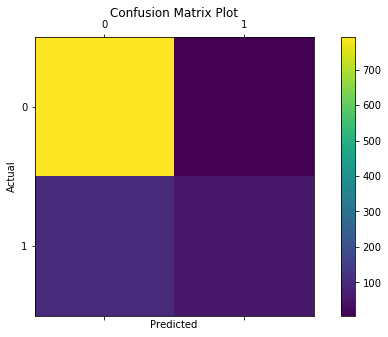

In [61]:
# Nice plot of confusion matrix
# Adjust size of confusion matrix by following code taken from StackOverflow
# https://stackoverflow.com/questions/43021762/matplotlib-how-to-change-figsize-for-matshow
plt.figure(figsize=(10,5))
plt.matshow(cm, fignum=1)

plt.title('Confusion Matrix Plot')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

## Decision Tree Classifier

In [62]:
from sklearn.tree import DecisionTreeClassifier
#dtc = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)
dtc = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)
predictions = dtc.predict(X_test)
print("Decision Tree Classifier Score For Unbalanced Dataset: {:.2f}".format(dtc.score(X_test, y_test)))

Decision Tree Classifier Score For Unbalanced Dataset: 0.98


In [63]:
print(dict(zip(predictors, dtc.feature_importances_)))

{'MW': 0.010661296140779292, 'grav': 0.010775145508624445, 'instability': 0.006168186868131832, 'isoelectric': 0.017192715786327046, 'aromaticity': 0.011127374384774668, 'helix': 0.94407528131136265}


In [64]:
# Generate Confusion Matrix for Decision Tree Classifier
actual = y_test
predictions = dtc.predict(X_test)
print('Confusion Matrix for Decision Tree Model Using Unbalanced Dataset')
print()
cm = confusion_matrix(actual,predictions)
print(cm)

Confusion Matrix for Decision Tree Model Using Unbalanced Dataset

[[790   8]
 [ 10 151]]


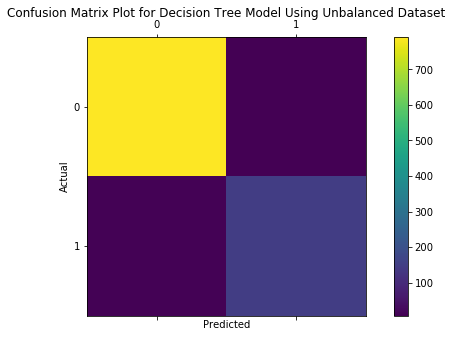

In [77]:
# Nice plot of confusion matrix
# Adjust size of confusion matrix by following code taken from StackOverflow
# https://stackoverflow.com/questions/43021762/matplotlib-how-to-change-figsize-for-matshow
plt.figure(figsize=(10,5))
plt.matshow(cm, fignum=1)

plt.title('Confusion Matrix Plot for Decision Tree Model Using Unbalanced Dataset')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

## Synthetic Data Using SMOTE To Address The Imbalance 

In [66]:
smt = SMOTE()
X_train, y_train = smt.fit_sample(X_train, y_train)

np.bincount(y_train)

array([3115, 3115])

In [67]:
# Logistic Regression for prediction
lr = LogisticRegression()
lr.fit(X_train, y_train)
predictions = lr.predict(X_test)
print(" Logistic Regression Classifier With SMOTE Synthetic Data Score: {:.2f}".format(lr.score(X_test, y_test)))

 Logistic Regression Classifier With SMOTE Synthetic Data Score: 0.98


/Users/scottlew/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [68]:
# Generate Confusion Matrix for Logistic Regression
actual = y_test
predictions = lr.predict(X_test)
print('Confusion Matrix for Logistic Regression Model Using Synthetic Balanced Dataset')
print()
cm = confusion_matrix(actual,predictions)
print(cm)

Confusion Matrix for Logistic Regression Model Using Synthetic Balanced Dataset

[[791   7]
 [ 12 149]]


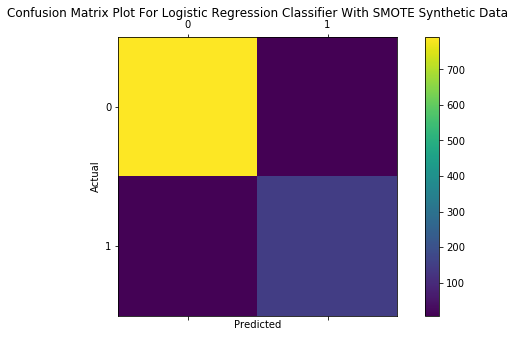

In [69]:
# Nice plot of confusion matrix
# Adjust size of confusion matrix by following code taken from StackOverflow
# https://stackoverflow.com/questions/43021762/matplotlib-how-to-change-figsize-for-matshow
plt.figure(figsize=(10,5))
plt.matshow(cm, fignum=1)

plt.title('Confusion Matrix Plot For Logistic Regression Classifier With SMOTE Synthetic Data')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

## Predict whether a well-known crystallizable protein, chicken lysozyme, will crystallize or not using MW, gravy, instability, isoelectric point, aromaticity, helical content. 

In [70]:
# The following sequence is for the hen egg white lysozyme protein which is known to crystallize
seq = 'KVFGRCELAAAMKRHGLDNYRGYSLGNWVCAAKFESNFNTQATNRNTDGSTDYGILQINSRWWCNDGRTPGSRNLCNIPCSALLSSDITASVNCAKKIVSDGNGMNAWVAWRNRCKGTDVQAWIRGCRL'

In [71]:
# 'MW', 'grav', 'instability', 'isoelectric','aromaticity', 'helix'
analysed_seq = ProteinAnalysis(seq)
X_ch = []
X_ch.append(analysed_seq.molecular_weight())
X_ch.append(analysed_seq.gravy())
X_ch.append(analysed_seq.instability_index())
X_ch.append(analysed_seq.isoelectric_point())
X_ch.append(analysed_seq.aromaticity())
X_ch.append(analysed_seq.secondary_structure_fraction()[0])

X_ch

[14313.003999999983,
 -0.47209302325581387,
 16.09147286821705,
 9.32379150390625,
 0.09302325581395349,
 0.24806201550387597]

In [72]:
X_ = x = np.array(X_ch)
X_.shape

(6,)

In [73]:
X_chicken = X_.reshape(1,6)
X_chicken.shape

(1, 6)

In [74]:
X_chicken

array([[  1.43130040e+04,  -4.72093023e-01,   1.60914729e+01,
          9.32379150e+00,   9.30232558e-02,   2.48062016e-01]])

In [75]:
predict = lr.predict(X_chicken)
predict[0]

1

## The Logistic Regression Model predicts lysozyme will crystallize!